# Projet 6 - Analyse les ventes d'une librairie Lapage

In [1]:
import pandas as pd
from pandas.core.resample import Grouper
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal, spearmanr, ttest_ind, chi2_contingency, pearsonr, shapiro
import datetime as dt
import math as mth
from statsmodels.tsa.seasonal import seasonal_decompose



In [2]:
#Importation de fichiers
customers = pd.read_csv('customers.csv', sep=";")
products = pd.read_csv('products.csv', sep=";")
Transactions = pd.read_csv('Transactions.csv', sep=";")

In [3]:
customers

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943
...,...,...,...
8616,c_7920,m,1956
8617,c_7403,f,1970
8618,c_5119,m,1974
8619,c_5643,f,1968


In [4]:
products

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0
...,...,...,...
3281,2_23,115.99,2
3282,0_146,17.14,0
3283,0_802,11.22,0
3284,1_140,38.56,1


In [5]:
Transactions

,id_prod,date,session_id,client_id
0,0_1259,2021-03-01 00:01:07.843138,s_1,c_329
1,0_1390,2021-03-01 00:02:26.047414,s_2,c_664
2,0_1352,2021-03-01 00:02:38.311413,s_3,c_580
3,0_1458,2021-03-01 00:04:54.559692,s_4,c_7912
4,0_1358,2021-03-01 00:05:18.801198,s_5,c_2033
...,...,...,...,...
687529,1_508,2023-02-28 23:49:03.148402,s_348444,c_3573
687530,2_37,2023-02-28 23:51:29.318531,s_348445,c_50
687531,1_695,2023-02-28 23:53:18.929676,s_348446,c_488
687532,0_1547,2023-02-28 23:58:00.107815,s_348447,c_4848


In [6]:
# Separation date et heure 
Transactions[['date', 'time']] = Transactions['date'].str.split(' ', expand=True)

# Conversion format date
Transactions['date'] = pd.to_datetime(Transactions['date'])

In [7]:
Transactions

,id_prod,date,session_id,client_id,time
0,0_1259,2021-03-01,s_1,c_329,00:01:07.843138
1,0_1390,2021-03-01,s_2,c_664,00:02:26.047414
2,0_1352,2021-03-01,s_3,c_580,00:02:38.311413
3,0_1458,2021-03-01,s_4,c_7912,00:04:54.559692
4,0_1358,2021-03-01,s_5,c_2033,00:05:18.801198
...,...,...,...,...,...
687529,1_508,2023-02-28,s_348444,c_3573,23:49:03.148402
687530,2_37,2023-02-28,s_348445,c_50,23:51:29.318531
687531,1_695,2023-02-28,s_348446,c_488,23:53:18.929676
687532,0_1547,2023-02-28,s_348447,c_4848,23:58:00.107815


In [8]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8621 entries, 0 to 8620
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  8621 non-null   object
 1   sex        8621 non-null   object
 2   birth      8621 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 202.2+ KB


In [9]:
#valeurs manqueantes
customers.isnull().any()

client_id    False
sex          False
birth        False
dtype: bool

In [10]:
customers.isna().sum()

client_id    0
sex          0
birth        0
dtype: int64

In [11]:
#premierès lignes
customers.sort_values('client_id', ascending = False).head(10)

,client_id,sex,birth
7357,c_999,m,1964
2145,c_998,m,2001
94,c_997,f,1994
2787,c_996,f,1970
7003,c_995,m,1955
7792,c_994,f,2002
5330,c_993,m,1968
666,c_992,f,1977
6587,c_991,m,1978
5610,c_990,m,1984


In [12]:
#dernierès lignes
customers.sort_values('client_id', ascending = False).tail(10)

,client_id,sex,birth
8456,c_1006,m,1979
708,c_1005,f,1941
6305,c_1004,m,1973
6484,c_1003,m,1982
1591,c_1002,f,1982
3425,c_1001,m,1982
8471,c_1000,f,1966
2137,c_100,m,1992
6893,c_10,m,1956
4298,c_1,m,1955


In [13]:
customers.duplicated().sum()

0

In [14]:
customers.describe()

,birth
count,8621.000000
mean,1978.275606
std,16.917958
min,1929.000000
25%,1966.000000
50%,1979.000000
75%,1992.000000
max,2004.000000


count : 8621 total d'éléments.
mean : 1978 (46ans) moyenne des valeurs.
std : 16.91 écart-type des valeurs.
min : 1929 (95ans) valeur minimale.
25% : Premier quartile 1966 (57ans) des valeurs, ce qui signifie que 25% des valeurs sont inférieures ou égales.
50% : Deuxième quartile 1979 (44ans) ou médiane des valeurs, ce qui signifie que 50% des valeurs sont inférieures ou égales à cette valeur.
75% : Troisième quartile 1992 (31ans), ce qui signifie que 75% des valeurs sont inférieures ou égales à cette valeur.
max : Valeur maximale 2004 (19ans).
Pas de valeurs aberrentes dans les années de naissance (min 2004 = 19 ans et max 1929 = 94 ans)

In [15]:
#répartition genre
f_vs_m = customers["sex"].value_counts().rename_axis('Femme/Homme').to_frame('sex').reset_index()
f_vs_m["Repartition"] = round((f_vs_m ["sex"] / f_vs_m ["sex"].sum())*100,2)
f_vs_m

,Femme/Homme,sex,Repartition
0,f,4490,52.08
1,m,4131,47.92


In [16]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3286 entries, 0 to 3285
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_prod  3286 non-null   object 
 1   price    3286 non-null   float64
 2   categ    3286 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 77.1+ KB


In [17]:
#valeurs manqueantes
products.isnull().any()

id_prod    False
price      False
categ      False
dtype: bool

In [18]:
products.isna().sum()

id_prod    0
price      0
categ      0
dtype: int64

In [19]:
#premierès lignes
products.sort_values('id_prod', ascending = False).head(10)

,id_prod,price,categ
3187,2_99,84.99,2
3087,2_98,149.74,2
2697,2_97,160.99,2
2575,2_96,47.91,2
965,2_95,98.99,2
706,2_94,145.45,2
2145,2_93,78.99,2
933,2_92,78.05,2
1924,2_91,96.99,2
2163,2_90,182.30,2


In [20]:
#dernierès lignes
products.sort_values('id_prod', ascending = False).tail(10)

,id_prod,price,categ
831,0_1005,20.99,0
673,0_1004,8.07,0
267,0_1003,14.99,0
1800,0_1002,8.31,0
1859,0_1001,4.99,0
921,0_1000,6.84,0
663,0_100,20.60,0
2690,0_10,17.95,0
802,0_1,10.99,0
1000,0_0,3.75,0


In [21]:
products.duplicated().sum()

0

In [22]:
products.describe()

,price,categ
count,3286.000000,3286.000000
mean,21.863597,0.370359
std,29.849786,0.615446
min,0.620000,0.000000
25%,6.990000,0.000000
50%,13.075000,0.000000
75%,22.990000,1.000000
max,300.000000,2.000000


count : Nombre total d'éléments 3286 pour price et 3286 pour categ.
mean : Moyenne des valeurs 21.863597 pour price et 0.370359 pour categ.
std : Écart-type des valeurs de 29.849786 pour price et 0.615446 pour categ.
min : Valeur minimale 0.620000 pour price.
25% : Premier quartile des valeurs 6.990000 pour price, ce qui signifie que 25% des valeurs sont inférieures ou égales à cette valeur.
50% : Deuxième quartile ou médiane des valeurs de 13.075000 pour price, ce qui signifie que 50% des valeurs sont inférieures ou égales à cette valeur.
75% : Troisième quartile des valeurs de 22.990000 pour price et 1 pour categ), ce qui signifie que 75% des valeurs sont inférieures ou égales à cette valeur.
max : Valeur maximale 300.000000 pour price et 2 pour categ).


In [23]:
Transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 687534 entries, 0 to 687533
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     687534 non-null  object        
 1   date        687534 non-null  datetime64[ns]
 2   session_id  687534 non-null  object        
 3   client_id   687534 non-null  object        
 4   time        687534 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 26.2+ MB


In [24]:
#valeurs manqueantes
Transactions.isnull().sum()

id_prod       0
date          0
session_id    0
client_id     0
time          0
dtype: int64

In [25]:
Transactions.isna().sum()

id_prod       0
date          0
session_id    0
client_id     0
time          0
dtype: int64

In [26]:
#premierès lignes
Transactions.sort_values('client_id', ascending = False).head(10)

,id_prod,date,session_id,client_id,time
159678,0_1442,2021-08-28,s_81831,c_999,13:12:42.429052
652268,1_727,2023-01-21,s_330231,c_999,17:40:50.856434
309023,1_247,2022-01-24,s_154462,c_999,09:39:50.831782
616391,1_407,2022-12-13,s_311465,c_999,15:31:15.583770
585240,1_676,2022-11-10,s_295726,c_999,23:59:59.414026
498207,1_251,2022-08-09,s_250655,c_999,09:06:38.818975
670667,1_676,2023-02-10,s_339757,c_999,23:59:59.414026
652258,1_351,2023-01-21,s_330231,c_999,17:16:06.807620
480582,1_727,2022-07-21,s_241673,c_999,17:40:50.856434
422954,1_351,2022-05-21,s_211960,c_999,17:16:06.807620


In [27]:
#dernierès lignes
Transactions.sort_values('client_id', ascending = False).tail(10)

,id_prod,date,session_id,client_id,time
628279,0_1448,2022-12-26,s_317678,c_1,17:37:29.438136
229397,2_208,2021-11-04,s_114737,c_1,17:28:13.934070
129143,0_513,2021-07-21,s_65433,c_1,22:41:38.769525
272614,0_1090,2021-12-19,s_136532,c_1,02:44:12.827475
566518,0_513,2022-10-21,s_286029,c_1,22:41:38.769525
624283,0_513,2022-12-21,s_315508,c_1,22:41:38.769525
211663,1_285,2021-10-15,s_105105,c_1,11:28:56.606533
211662,1_433,2021-10-15,s_105105,c_1,11:28:27.540834
211661,1_593,2021-10-15,s_105105,c_1,11:28:26.793443
269282,1_364,2021-12-15,s_134971,c_1,23:32:41.632729


In [28]:
#doublons
Transactions.duplicated().sum()

0

Conclusion:
dataframes sont nettoyés et vérifié, pas doublons, pas de valeurs manquantes, nulles. 

Merge des dataframes:

In [29]:
# Clé de df Transactions, customers ='client_id'
# Clé new df et nouveau = 'id_prod'
bd = pd.merge(Transactions, customers, on='client_id', how='left')
newbd = pd.merge(bd, products, on='id_prod', how='left')


Avec le paramètre how='left' dans les fonctions merge(), pour garantir que tous les clients du newbd sont conservés, même s'ils n'ont pas de transactions correspondantes dans le dataframe Transactions. 

In [30]:
newbd

,id_prod,date,session_id,client_id,time,sex,birth,price,categ
0,0_1259,2021-03-01,s_1,c_329,00:01:07.843138,f,1967,11.99,0
1,0_1390,2021-03-01,s_2,c_664,00:02:26.047414,m,1960,19.37,0
2,0_1352,2021-03-01,s_3,c_580,00:02:38.311413,m,1988,4.50,0
3,0_1458,2021-03-01,s_4,c_7912,00:04:54.559692,f,1989,6.55,0
4,0_1358,2021-03-01,s_5,c_2033,00:05:18.801198,f,1956,16.49,0
...,...,...,...,...,...,...,...,...,...
687529,1_508,2023-02-28,s_348444,c_3573,23:49:03.148402,f,1996,21.92,1
687530,2_37,2023-02-28,s_348445,c_50,23:51:29.318531,f,1994,48.99,2
687531,1_695,2023-02-28,s_348446,c_488,23:53:18.929676,f,1985,26.99,1
687532,0_1547,2023-02-28,s_348447,c_4848,23:58:00.107815,m,1953,8.99,0


In [31]:
# creation colonne 'age'
current_year = 2023
newbd['age'] = current_year - newbd['birth']

print(newbd)


       id_prod       date session_id client_id             time sex  birth  \
0       0_1259 2021-03-01        s_1     c_329  00:01:07.843138   f   1967   
1       0_1390 2021-03-01        s_2     c_664  00:02:26.047414   m   1960   
2       0_1352 2021-03-01        s_3     c_580  00:02:38.311413   m   1988   
3       0_1458 2021-03-01        s_4    c_7912  00:04:54.559692   f   1989   
4       0_1358 2021-03-01        s_5    c_2033  00:05:18.801198   f   1956   
...        ...        ...        ...       ...              ...  ..    ...   
687529   1_508 2023-02-28   s_348444    c_3573  23:49:03.148402   f   1996   
687530    2_37 2023-02-28   s_348445      c_50  23:51:29.318531   f   1994   
687531   1_695 2023-02-28   s_348446     c_488  23:53:18.929676   f   1985   
687532  0_1547 2023-02-28   s_348447    c_4848  23:58:00.107815   m   1953   
687533  0_1398 2023-02-28   s_348435    c_3575  23:58:30.792755   f   1981   

        price  categ  age  
0       11.99      0   56  
1      


1) Mission data analyst (Antoine): 
- évolution chiffre d'affaires dans le temps (par mois)
- décomposition en moyenne mobile pour évaluer la tendance globale
- profile de client (ca par client, répartition par catégorie: âge et sexe, catégorie de produits achetés, montant total dépensé et la fréquence d'achat)
- courbe de Lorenz (relation entre les revenus et comportement entre clients)
- zoom sur les références (top 10 meilleurs et pire vente)
- finalement analysis de prix (le plus et moins cher et sa catégorie)



# Evolution chiffre d'affaire dans le temps


In [32]:
# grouper le transactions par mois
chiffre_par_mois = newbd.groupby(newbd['date'].dt.to_period('M'))['price'].sum()

# affichage
print(chiffre_par_mois)

date
2021-03    482440.61
2021-04    476109.30
2021-05    492943.47
2021-06    484088.56
2021-07    482835.40
2021-08    482284.79
2021-09    507240.68
2021-10    494733.16
2021-11    516167.73
2021-12    525917.28
2022-01    525338.99
2022-02    535571.50
2022-03    515456.53
2022-04    492998.94
2022-05    517132.60
2022-06    496016.12
2022-07    510783.12
2022-08    506467.27
2022-09    494114.53
2022-10    507917.77
2022-11    496664.94
2022-12    510219.50
2023-01    517540.55
2023-02    456679.76
Freq: M, Name: price, dtype: float64


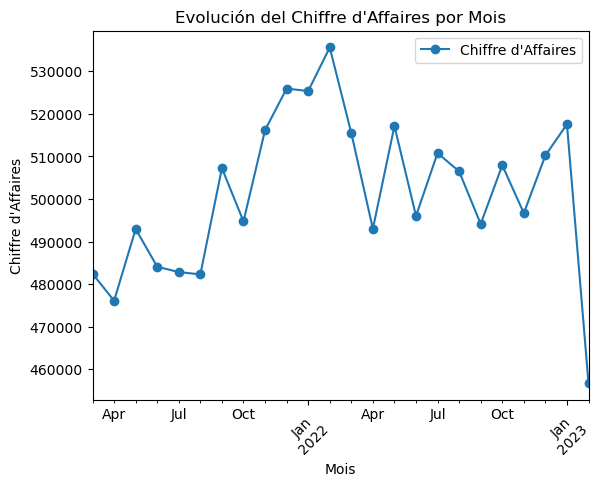

In [33]:
fig, ax = plt.subplots()

# Graphique univarié
chiffre_par_mois.plot(kind='line', ax=ax, marker='o', linestyle='-')

# titres
ax.set_title("Evolución del Chiffre d'Affaires por Mois")
ax.set_xlabel("Mois")
ax.set_ylabel("Chiffre d'Affaires")

# Rotation
plt.xticks(rotation=45)

# legends
plt.legend(["Chiffre d'Affaires"])

# affichage
plt.show()

Globalement, le chiffre d'affaires semble augmenter de manière stable jusqu'à la fin de l'année 2022. Cependant, une forte baisse est observée en janvier 2023, suivie d'une reprise progressive mais pas complète du chiffre d'affaires au cours des mois suivants.

Cette baisse significative en janvier 2023 pourrait être due à plusieurs facteurs:
tels que des conditions économiques défavorables, 
une diminution de la demande des clients, 
des problèmes de disponibilité des produits ou 
des changements dans les habitudes d'achat des clients, à analyser... 


# Décomposition en moyenne mobile pour évaluer la tendance globale 
comprendre la décomposition de chiffre d'affaires

In [34]:
#d'abord vérification si les mois sont complets
dates_str = chiffre_par_mois.index.strftime('%Y-%m')
mois_complet = newbd['date'].dt.date.value_counts().shape[0] == len(pd.date_range(newbd['date'].dt.date.min(), newbd['date'].dt.date.max()))

if mois_complet:
    print("Les mois contienent tous ces jours.")
else:
    print("Les mois sont incomplet.")

Les mois contienent tous ces jours.


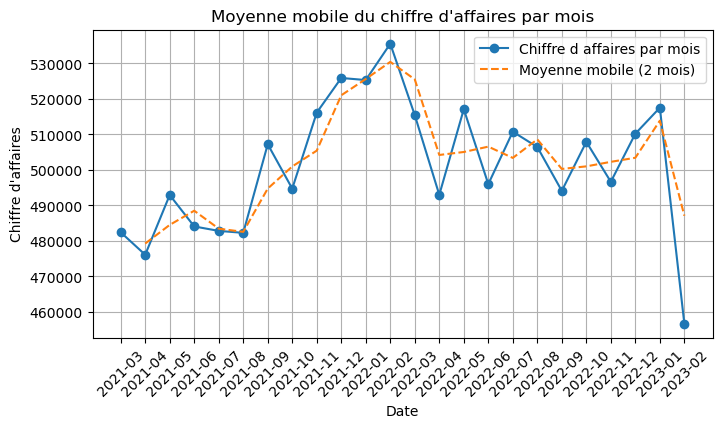

date
2021-03           NaN
2021-04    479274.955
2021-05    484526.385
2021-06    488516.015
2021-07    483461.980
2021-08    482560.095
2021-09    494762.735
2021-10    500986.920
2021-11    505450.445
2021-12    521042.505
2022-01    525628.135
2022-02    530455.245
2022-03    525514.015
2022-04    504227.735
2022-05    505065.770
2022-06    506574.360
2022-07    503399.620
2022-08    508625.195
2022-09    500290.900
2022-10    501016.150
2022-11    502291.355
2022-12    503442.220
2023-01    513880.025
2023-02    487110.155
Freq: M, Name: price, dtype: float64

In [68]:
moyenne_mobile = chiffre_par_mois.rolling(window=2).mean()
 
# print
plt.figure(figsize=(8, 4))
plt.plot(dates_str, chiffre_par_mois.values, label='Chiffre d affaires par mois', marker='o', linestyle='-')
plt.plot(dates_str, moyenne_mobile.values, label='Moyenne mobile (2 mois)', linestyle='--')
plt.title("Moyenne mobile du chiffre d'affaires par mois")
plt.xlabel("Date")
plt.ylabel("Chiffre d'affaires")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

moyenne_mobile


Rappel:
La décomposition en moyenne mobile est une technique utilisée pour analyser les tendances temporelles dans les données. 

Explication:
La moyenne mobile reflète comment le chiffre d'affaires moyen par client a évolué en fonction des données historiques. Voici une analyse basée sur les données fournies :
- Au début, en mars 2021, la moyenne mobile est NaN (non disponible) car il n'y a pas de données antérieures pour calculer la moyenne mobile.
- En avançant dans le temps, on constate que la moyenne mobile commence à augmenter progressivement à partir d'avril 2021 jusqu'à atteindre un pic en janvier 2022.
- Après avoir atteint son maximum, la moyenne mobile semble fluctuer un peu, montrant quelques pics et creux, mais dans l'ensemble, elle semble se maintenir à un niveau élevé.
- Cependant, vers la fin de la série temporelle, en février 2023, on observe une diminution significative de la moyenne mobile par rapport aux mois précédents.

En résumé, la moyenne mobile reflète une tendance générale à la hausse du chiffre d'affaires par client au cours de la période observée, avec quelques fluctuations mineures. Cependant, vers la fin de la série temporelle, une diminution de la tendance à la hausse est observée.

# Profile client

In [72]:
# D'abord, combien de client unique par mois

#filtrer année et mois dans colonne 'date'
newbd['année_mois'] = newbd['date'].dt.to_period('M')
client_par_mois = newbd.groupby('année_mois')['client_id'].nunique()

# affichage
print(client_par_mois)

année_mois
2021-03    5676
2021-04    5674
2021-05    5644
2021-06    5659
2021-07    5672
2021-08    5642
2021-09    5693
2021-10    6190
2021-11    5875
2021-12    5867
2022-01    5809
2022-02    5729
2022-03    5835
2022-04    5695
2022-05    5843
2022-06    5717
2022-07    5778
2022-08    5805
2022-09    5738
2022-10    5755
2022-11    5749
2022-12    5765
2023-01    5828
2023-02    5587
Freq: M, Name: client_id, dtype: int64


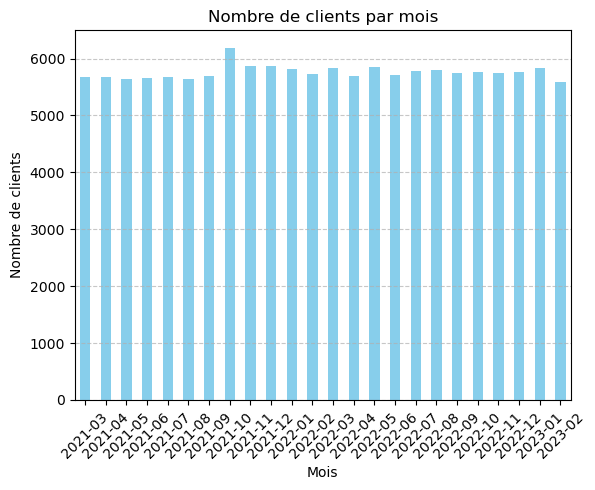

In [37]:
#Graphique bar univarié
client_par_mois.plot(kind='bar', color='skyblue')
plt.title("Nombre de clients par mois")
plt.xlabel("Mois")
plt.ylabel("Nombre de clients")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [38]:
# Total de chiffre d'affaires et transactions
ca_total = chiffre_par_mois.sum()
transactions = newbd['session_id'].count()
print ("Avec un total de", transactions,"transactions", "le total de chiffre d'affaire c'était de:", ca_total, "€")

Avec un total de 687534 transactions le total de chiffre d'affaire c'était de: 12027663.100000001 €


In [39]:
#Combien aport chaque client par mois
total_ca_per_client = newbd.groupby('client_id')['price'].sum().sort_values(ascending=False)
total_ca_per_client


client_id
c_1609    326039.89
c_4958    290227.03
c_6714    153918.60
c_3454    114110.57
c_1570      5285.82
            ...    
c_4478        13.36
c_4648        11.20
c_8114         9.98
c_8140         8.30
c_8351         6.31
Name: price, Length: 8600, dtype: float64

In [40]:
# apport en percentage par client
percentage_ca_par_client = total_ca_per_client.cumsum() / total_ca_per_client.sum()
percentage_ca_par_client

client_id
c_1609    0.027108
c_4958    0.051237
c_6714    0.064035
c_3454    0.073522
c_1570    0.073961
            ...   
c_4478    0.999997
c_4648    0.999998
c_8114    0.999999
c_8140    0.999999
c_8351    1.000000
Name: price, Length: 8600, dtype: float64

Selon la liste de top client, le client_id c_1609 a apporté le plus, et le suivi le c_4958, c_6714 et c_3454, donc 4 gros clients, peut être sont des BtoB: libraires, revendeurs, bibliothécaires, etc.
peut être je peux enlèver ces clients du df.

In [41]:
client_id_btob = ['c_1609', 'c_4958', 'c_6714', 'c_3454', 'c_1570']
newbd_BtoC = newbd[~newbd['client_id'].isin(client_id_btob)]

newbd_BtoC


,id_prod,date,session_id,client_id,time,sex,birth,price,categ,age,année_mois
0,0_1259,2021-03-01,s_1,c_329,00:01:07.843138,f,1967,11.99,0,56,2021-03
1,0_1390,2021-03-01,s_2,c_664,00:02:26.047414,m,1960,19.37,0,63,2021-03
2,0_1352,2021-03-01,s_3,c_580,00:02:38.311413,m,1988,4.50,0,35,2021-03
3,0_1458,2021-03-01,s_4,c_7912,00:04:54.559692,f,1989,6.55,0,34,2021-03
4,0_1358,2021-03-01,s_5,c_2033,00:05:18.801198,f,1956,16.49,0,67,2021-03
...,...,...,...,...,...,...,...,...,...,...,...
687529,1_508,2023-02-28,s_348444,c_3573,23:49:03.148402,f,1996,21.92,1,27,2023-02
687530,2_37,2023-02-28,s_348445,c_50,23:51:29.318531,f,1994,48.99,2,29,2023-02
687531,1_695,2023-02-28,s_348446,c_488,23:53:18.929676,f,1985,26.99,1,38,2023-02
687532,0_1547,2023-02-28,s_348447,c_4848,23:58:00.107815,m,1953,8.99,0,70,2023-02


In [51]:
client_id_btob = ['c_1609', 'c_4958', 'c_6714', 'c_3454', 'c_1570']
newbd_BtoB = newbd[newbd['client_id'].isin(client_id_btob)]

newbd_BtoB


,id_prod,date,session_id,client_id,time,sex,birth,price,categ,age,année_mois
6,0_1304,2021-03-01,s_7,c_1609,00:07:04.371179,m,1980,5.86,0,43,2021-03
13,0_1159,2021-03-01,s_7,c_1609,00:11:57.832228,m,1980,7.99,0,43,2021-03
50,0_1431,2021-03-01,s_33,c_3454,01:08:49.803921,m,1969,10.99,0,54,2021-03
78,0_1425,2021-03-01,s_46,c_1609,01:56:41.944044,m,1980,12.99,0,43,2021-03
88,0_1469,2021-03-01,s_53,c_1609,02:12:21.294004,m,1980,14.99,0,43,2021-03
...,...,...,...,...,...,...,...,...,...,...,...
687482,0_1333,2023-02-28,s_348416,c_6714,22:40:24.405750,f,1968,5.99,0,55,2023-02
687494,1_392,2023-02-28,s_348416,c_6714,23:04:51.081903,f,1968,18.11,1,55,2023-02
687496,2_13,2023-02-28,s_348403,c_4958,23:08:40.035146,m,1999,50.99,2,24,2023-02
687498,1_183,2023-02-28,s_348416,c_6714,23:10:49.235323,f,1968,24.99,1,55,2023-02


In [52]:
#répartition genre
f_vs_m = newbd_BtoC["sex"].value_counts().rename_axis('Femme/Homme').to_frame('sex').reset_index()
f_vs_m["Repartition"] = round((f_vs_m ["sex"] / f_vs_m ["sex"].sum())*100,2)
f_vs_m

,Femme/Homme,sex,Repartition
0,f,333124,52.02
1,m,307240,47.98


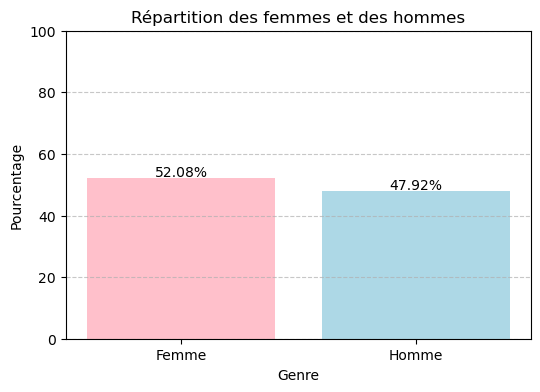

In [53]:
sex = ['Femme', 'Homme']
repartition = [52.08, 47.92]

# Création du graphique à barres
plt.figure(figsize=(6, 4))
plt.bar(sex, repartition, color=['pink', 'lightblue'])

# Ajout des étiquettes
for i in range(len(sex)):
    plt.text(i, repartition[i] + 0.5, f'{repartition[i]}%', ha='center')

# Personnalisation du graphique
plt.title('Répartition des femmes et des hommes')
plt.xlabel('Genre')
plt.ylabel('Pourcentage')
plt.ylim(0, 100)  # Définir les limites de l'axe y de 0 à 100
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Affichage du graphique
plt.show()

In [54]:
ventes_par_genre = newbd_BtoC .groupby('sex')['price'].sum()
somme_masculin = newbd_BtoC [newbd['sex'] == 'm']['price'].sum()

# Calculer la somme totale dépensée par les clients féminins
somme_feminin = newbd_BtoC [newbd_BtoC ['sex'] == 'f']['price'].sum()

print("Somme totale dépensée par les clients masculins :", somme_masculin)
print("Somme totale dépensée par les clients féminins :", somme_feminin)
# Comparer les sommes pour voir quel groupe a dépensé le plus au total
if ventes_par_genre['f'] > ventes_par_genre['m']:
    print("Le sexe féminin a dépensé plus au total.")
elif ventes_par_genre['f'] < ventes_par_genre['m']:
    print("Le sexe masculin a dépensé plus au total.")
else:
    print("Les dépenses totales sont égales pour les deux sexes.")

/var/folders/cy/t20bxd4s1n30wgrjxd5xxwpr0000gn/T/ipykernel_68102/1160015441.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  somme_masculin = newbd_BtoC [newbd['sex'] == 'm']['price'].sum()


Somme totale dépensée par les clients masculins : 5346441.929999999
Somme totale dépensée par les clients féminins : 5791639.260000002
Le sexe féminin a dépensé plus au total.


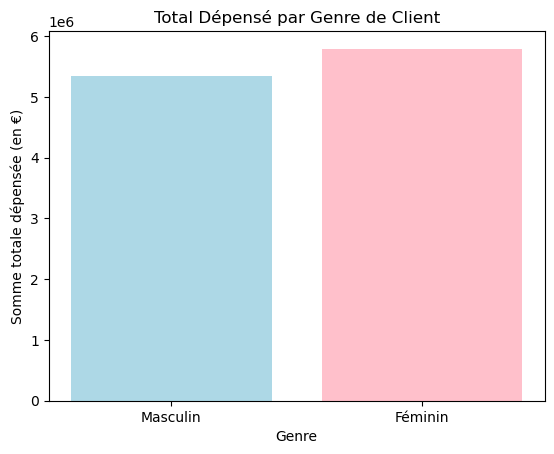

[5346441.929999999, 5791639.260000002]

In [55]:
categories = ['Masculin', 'Féminin']
sommes = [somme_masculin, somme_feminin]

# graphique à barres
plt.bar(categories, sommes, color=['lightblue', 'pink'])

# titre
plt.title("Total Dépensé par Genre de Client")
plt.xlabel("Genre")
plt.ylabel("Somme totale dépensée (en €)")

# Affichage
plt.show()
sommes

In [56]:
# Par âge et genre
age_sex = newbd_BtoC.groupby(['sex', 'age']).size().unstack()
age_sex

age,19,20,21,22,23,24,25,26,27,28,...,85,86,87,88,89,90,91,92,93,94
sex,,,,,,,,,,,,,,,,,,,,,
f,8063,2063,1971,2550,2649,2467,2617,2537,2948,3469,...,525,734,638,227,292,250,288,47,185,49
m,7434,2428,2740,1828,1880,2700,2368,2311,3249,2339,...,323,212,126,51,266,86,24,123,53,153


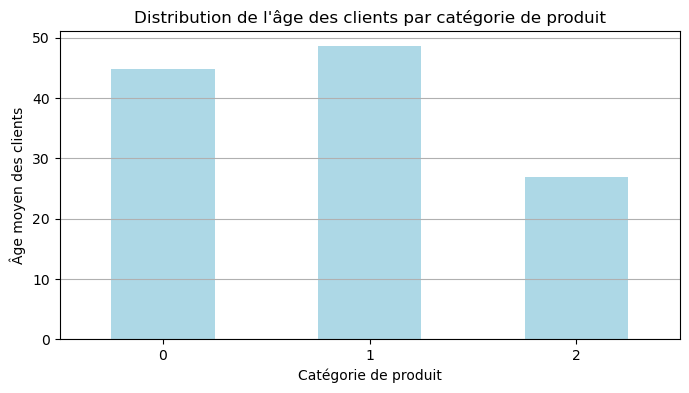

La catégorie 0 est achète par client de moins 45 ans
La catégorie 1 est achète par client de moins 48 ans
La catégorie 2 est achète par client de moins 28 ans


In [57]:
# Répartition âge par catégorie de produit

age_par_categorie = newbd_BtoC.groupby('categ')['age'].describe()

# Affichage de la distribution de l'âge des clients par catégorie de produit
plt.figure(figsize=(8, 4))
age_par_categorie['mean'].plot(kind='bar', color='lightblue')
plt.title("Distribution de l'âge des clients par catégorie de produit")
plt.xlabel("Catégorie de produit")
plt.ylabel("Âge moyen des clients")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

print ("La catégorie 0 est achète par client de moins 45 ans")
print ("La catégorie 1 est achète par client de moins 48 ans")
print ("La catégorie 2 est achète par client de moins 28 ans")

In [77]:
# Par le montant total dépensé
total_dépensé = newbd_BtoC.groupby('client_id')['price'].sum()

# Trier les clients par le montant total dépensé
total_dépensé_trié = total_dépensé.sort_values(ascending=False)

# Tracer les 10 principaux clients par montant total dépensé
top_clients = total_dépensé_trié.head(10)
top_client_qui_ont_moins_dépensé = total_dépensé_trié.tail(10)


print ("Le top 10 clients qui ont dépensé plus:", top_clients)
print ("Le top 10 clients qui ont moins dépensé:", top_client_qui_ont_moins_dépensé)

Le top 10 clients qui ont dépensé plus: client_id
c_3263    5276.87
c_2140    5260.18
c_2899    5214.05
c_7319    5155.77
c_7959    5135.75
c_1422    5131.36
c_7421    5097.18
c_8026    5082.58
c_2505    5059.35
c_1876    5026.60
Name: price, dtype: float64
Le top 10 clients qui ont moins dépensé: client_id
c_4976    17.89
c_8032    17.64
c_5829    16.07
c_5919    15.98
c_6040    15.72
c_4478    13.36
c_4648    11.20
c_8114     9.98
c_8140     8.30
c_8351     6.31
Name: price, dtype: float64


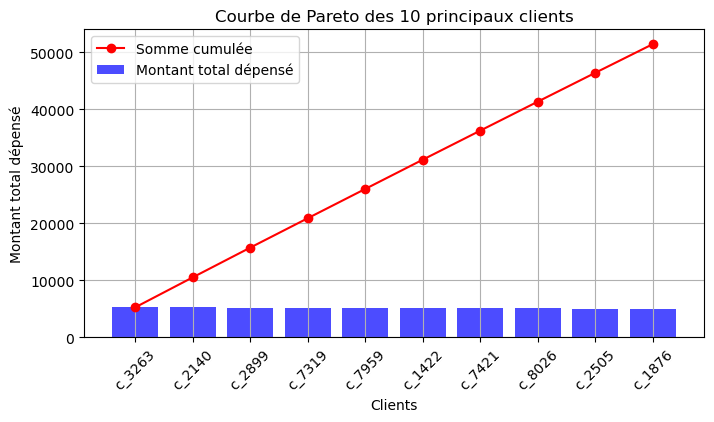

In [78]:
# courbe de Pareto
somme_cumulée = top_clients.cumsum()

# Tracer la courbe de Pareto
plt.figure(figsize=(8, 4))
plt.bar(range(len(top_clients)), top_clients, color='b', alpha=0.7)
plt.plot(range(len(top_clients)), somme_cumulée, color='r', marker='o')
plt.title('Courbe de Pareto des 10 principaux clients')
plt.xlabel('Clients')
plt.ylabel('Montant total dépensé')
plt.xticks(range(len(top_clients)), top_clients.index, rotation=45)
plt.legend(['Somme cumulée', 'Montant total dépensé'])
plt.grid(True)

plt.show()

En utilisant cette courbe, il est possible de voir clairement quels clients contribuent le plus aux ventes totales, ce qui peut être utile pour prendre des décisions commerciales stratégiques telles que cibler ces clients pour des offres spéciales ou des programmes de fidélisation.



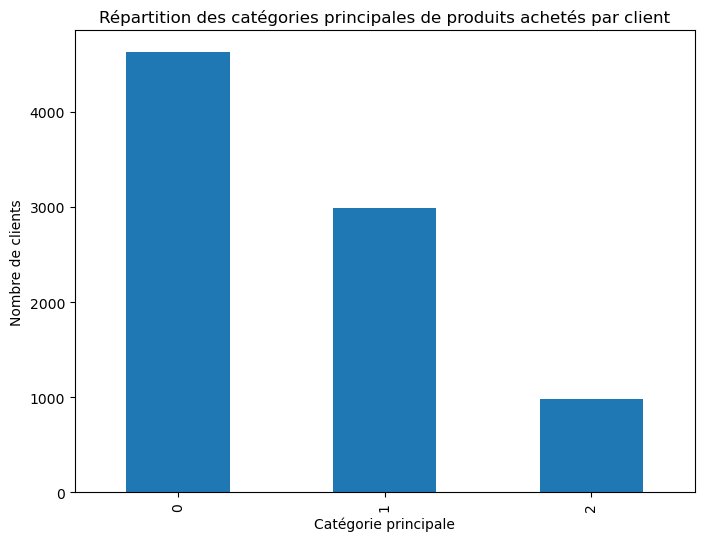

In [60]:
# Par catégorie de produits achetés :
category_grouped = newbd_BtoC.groupby(['client_id', 'categ']).size().unstack(fill_value=0)

# Calculer la catégorie la plus achetée par chaque client
category_grouped['catégorie_principale'] = category_grouped.idxmax(axis=1)

# Compter le nombre de clients par catégorie principale
nombre_clients_catégorie_principale = category_grouped['catégorie_principale'].value_counts()

# Tracer la distribution des catégories principales
nombre_clients_catégorie_principale.plot(kind='bar', figsize=(8, 6))
plt.title('Répartition des catégories principales de produits achetés par client')
plt.xlabel('Catégorie principale')
plt.ylabel('Nombre de clients')
plt.show()

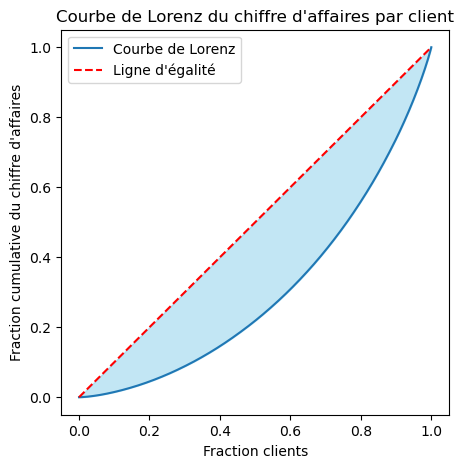

Indice de Gini: 0.3980468398164395
Un indice de Gini de 0.39 indique une inégalité modérée dans la répartition du chiffre d'affaires entre les clients.
Cela signifie qu'il y a une certaine disparité dans la façon dont le chiffre d'affaires est réparti parmi les clients.
mais que cette disparité n'est pas extrême..
Plus l'indice de Gini est proche de 1, plus l'inégalité est élevée.


In [61]:
# Courbe de Lorenz
#Rappel:
#La courbe de Lorenz permettra de visualiser comment le chiffre d'affaires est réparti entre les clients. 
#Si la courbe de Lorenz se rapproche de la ligne de l'égalité parfaite (ligne rouge en pointillés), cela signifie que la distribution du chiffre d'affaires 
# est plus équitable entre les clients. Si la courbe est en dessous de la ligne d'égalité parfaite, cela indique une inégalité dans la 
#répartition du chiffre d'affaires.

# Calcul du chiffre d'affaires total par client
chiffre_affaires_par_client = newbd_BtoC.groupby('client_id')['price'].sum().sort_values()

# Calcul de la distribution cumulative du chiffre d'affaires par client
distribution_cumulative_chiffre_affaires = chiffre_affaires_par_client.cumsum() / chiffre_affaires_par_client.sum()

# Calcul de la distribution cumulative de la population
distribution_cumulative_population = np.linspace(0, 1, len(chiffre_affaires_par_client))

# Tracé de la courbe de Lorenz
plt.figure(figsize=(5, 5))
plt.plot(distribution_cumulative_population, distribution_cumulative_chiffre_affaires, label='Courbe de Lorenz')
plt.plot(distribution_cumulative_population, distribution_cumulative_population, label="Ligne d'égalité", linestyle='--', color='red')
plt.fill_between(distribution_cumulative_population, distribution_cumulative_population, distribution_cumulative_chiffre_affaires, color='skyblue', alpha=0.5)
plt.xlabel("Fraction clients")
plt.ylabel("Fraction cumulative du chiffre d'affaires")
plt.title("Courbe de Lorenz du chiffre d'affaires par client")
plt.legend()
plt.show()

courb_lorenz = distribution_cumulative_chiffre_affaires.sum() / len(chiffre_affaires_par_client)

# Calcul de l'indice de Gini
indice_gini = (0.5 - courb_lorenz) / 0.5

print("Indice de Gini:", indice_gini)
print ("Un indice de Gini de 0.39 indique une inégalité modérée dans la répartition du chiffre d'affaires entre les clients.")
print ("Cela signifie qu'il y a une certaine disparité dans la façon dont le chiffre d'affaires est réparti parmi les clients.")
print ("mais que cette disparité n'est pas extrême..")
print ("Plus l'indice de Gini est proche de 1, plus l'inégalité est élevée.")



# Zoom sur les références, les tops et les flops, la répartition par catégorie, etc.

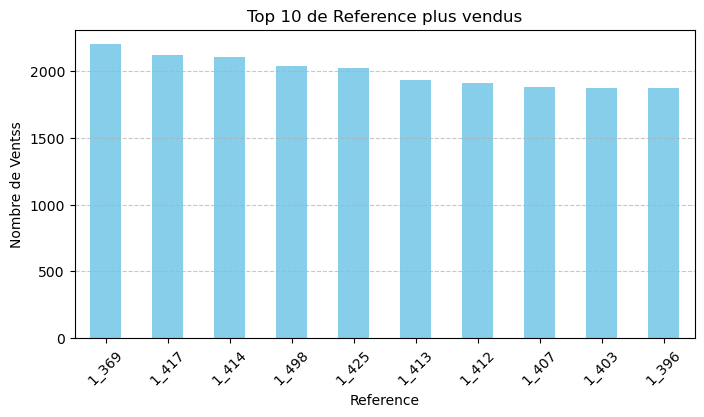

In [62]:
# Analyse des ventes par référence :
ventes_par_ref = newbd_BtoC['id_prod'].value_counts()

# top 10 plus vendus
top_10_refe = ventes_par_ref.head(10)

# Graphique bar
plt.figure(figsize=(8, 4))
top_10_refe.plot(kind='bar', color='skyblue')
plt.title('Top 10 de Reference plus vendus')
plt.xlabel('Reference')
plt.ylabel('Nombre de Ventss')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


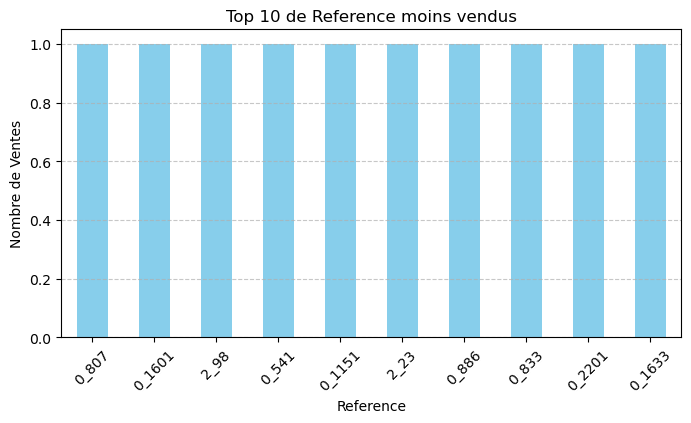

In [63]:
# Analyse des ventes par référence :
ventes_par_ref = newbd['id_prod'].value_counts()

# top 10 plus vendus
top_10_refe_moins_vendu = ventes_par_ref.tail(10)

# Graphique bar
plt.figure(figsize=(8, 4))
top_10_refe_moins_vendu.plot(kind='bar', color='skyblue')
plt.title('Top 10 de Reference moins vendus')
plt.xlabel('Reference')
plt.ylabel('Nombre de Ventes')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Le top 10 de ventes proviennent de la catégorie 1 et le pire de 0.

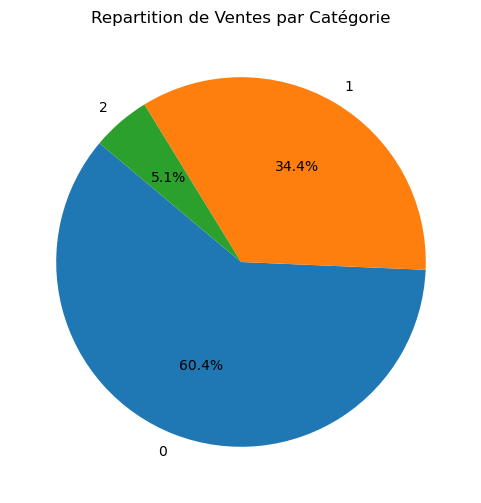

In [64]:
ventes_par_category = newbd_BtoC['categ'].value_counts()

# Graphique camenberg
plt.figure(figsize=(6, 6))
plt.pie(ventes_par_category, labels=ventes_par_category.index, autopct='%1.1f%%', startangle=140)
plt.title('Repartition de Ventes par Catégorie')
plt.show()

3 - Analyse des prix : identifier les produits les plus chers et les moins chers, ainsi que les tendances de prix dans différentes catégories.

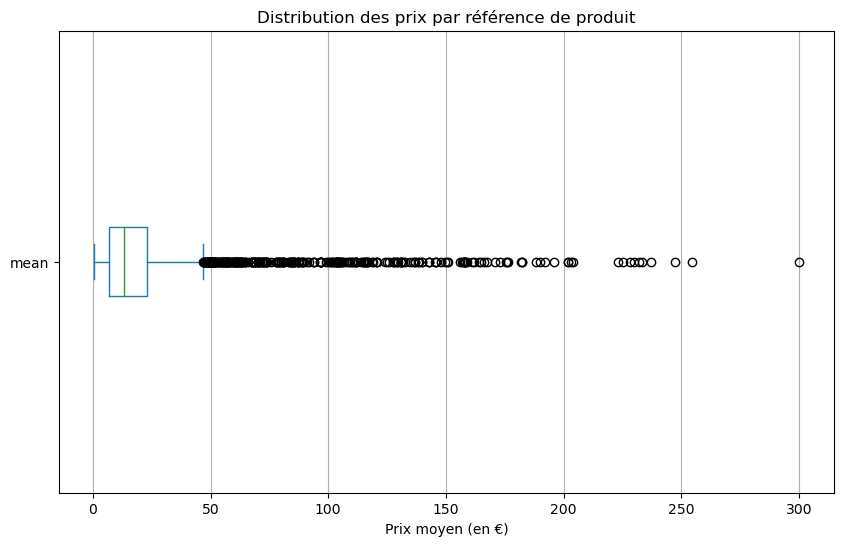

Produit le plus cher : 2_2 300.0 €
Produit le moins cher : 0_202 0.62 €


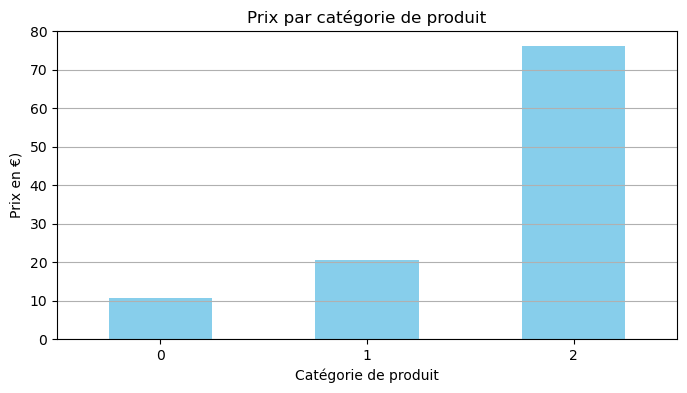

In [67]:
prix_par_reference = newbd_BtoC.groupby('id_prod')['price'].describe()

# Visualisation des prix par référence avec un box plot
plt.figure(figsize=(10, 6))
prix_par_reference['mean'].plot(kind='box', vert=False)
plt.title("Distribution des prix par référence de produit")
plt.xlabel("Prix moyen (en €)")
plt.grid(axis='x')
plt.show()

# Identification des produits les plus chers et les moins chers
produit_plus_cher = prix_par_reference['mean'].idxmax()
prix_plus_cher = prix_par_reference['mean'].max()
produit_moins_cher = prix_par_reference['mean'].idxmin()
prix_moins_cher = prix_par_reference['mean'].min()

print("Produit le plus cher :", produit_plus_cher,prix_plus_cher, "€")
print("Produit le moins cher :", produit_moins_cher, prix_moins_cher, "€")

# Analyse des tendances de prix par catégorie
prix_par_categorie = newbd_BtoC.groupby('categ')['price'].mean()

plt.figure(figsize=(8, 4))
prix_par_categorie.plot(kind='bar', color='skyblue')
plt.title("Prix par catégorie de produit")
plt.xlabel("Catégorie de produit")
plt.ylabel("Prix en €)")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

# Mission 2 (Julie): comportements des clients
## 5 corrélations:

In [65]:
#Identification variables sur le newbd
newbd_BtoC

,id_prod,date,session_id,client_id,time,sex,birth,price,categ,age,année_mois
0,0_1259,2021-03-01,s_1,c_329,00:01:07.843138,f,1967,11.99,0,56,2021-03
1,0_1390,2021-03-01,s_2,c_664,00:02:26.047414,m,1960,19.37,0,63,2021-03
2,0_1352,2021-03-01,s_3,c_580,00:02:38.311413,m,1988,4.50,0,35,2021-03
3,0_1458,2021-03-01,s_4,c_7912,00:04:54.559692,f,1989,6.55,0,34,2021-03
4,0_1358,2021-03-01,s_5,c_2033,00:05:18.801198,f,1956,16.49,0,67,2021-03
...,...,...,...,...,...,...,...,...,...,...,...
687529,1_508,2023-02-28,s_348444,c_3573,23:49:03.148402,f,1996,21.92,1,27,2023-02
687530,2_37,2023-02-28,s_348445,c_50,23:51:29.318531,f,1994,48.99,2,29,2023-02
687531,1_695,2023-02-28,s_348446,c_488,23:53:18.929676,f,1985,26.99,1,38,2023-02
687532,0_1547,2023-02-28,s_348447,c_4848,23:58:00.107815,m,1953,8.99,0,70,2023-02


Variables qualitatives :
- Les id (client_id, id_prod, session_id)
- Les catégories produits (0, 1 ou 2)
- Le genre des customes (f ou m)
- Les dates de Transactions (de 2021-03-01 à 2022-02-28)


Variable quantitative :
- Les prix products


# 1 - Lien entre le genre d'un client et les catégories :
Je vais utiliser une table de contingence (tableau croisé) soit un test statistique comme le test du (khi²) pour évaluer la dépendance entre le genre des clients et les catégories de produits achetés.

Rappel:
khi² sur un tableau de contingence: test d'association entre deux variables qualitatives

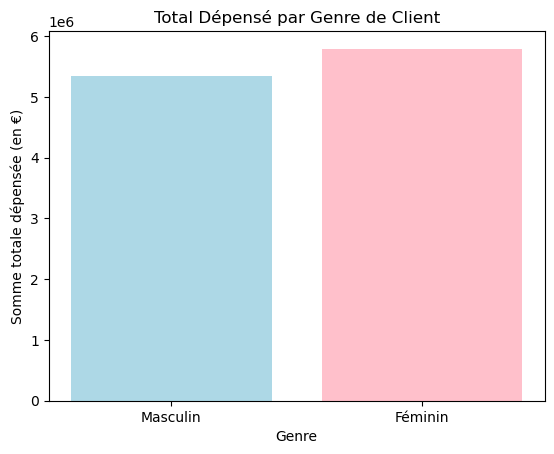

[5346441.929999999, 5791639.260000002]

In [74]:
genre = ['Masculin', 'Féminin']
sommes = [somme_masculin, somme_feminin]

# graphique à barres
plt.bar(genre, sommes, color=['lightblue', 'pink'])

# titre
plt.title("Total Dépensé par Genre de Client")
plt.xlabel("Genre")
plt.ylabel("Somme totale dépensée (en €)")

# Affichage
plt.show()
sommes

categ       0       1      2
sex                         
f      200533  115612  16979
m      186488  104884  15868
khi² statistic: 23.01737485800994
P-value: 1.0042470291396563e-05


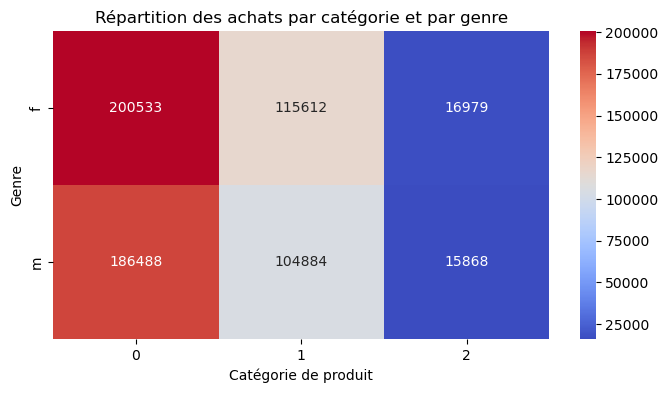

In [78]:
# 1. Créer une table de contingence
contingency_table = pd.crosstab(newbd_BtoC['sex'], newbd_BtoC['categ'])
print (contingency_table)

# 2. Effectuer le test du khi-deux
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print("khi² statistic:", chi2)
print("P-value:", p)

plt.figure(figsize=(8, 4))
sns.heatmap(contingency_table, annot=True, cmap='coolwarm', fmt='d')
plt.title("Répartition des achats par catégorie et par genre")
plt.xlabel("Catégorie de produit")
plt.ylabel("Genre")
plt.show()

J'ai utilisé le "Test d'association entre deux variables qualitatives" 
Les résultats du test indiquent une statistique du test de 23,02 avec une valeur p (p-value) très très faible (1.00e-05). Cela suggère qu'il existe une dépendance significative entre le genre des clients et les catégories de produits achetés. En d'autres termes, le genre des clients semble influencer le type de produits qu'ils achètent.

Le graphique heatmap confirme qu'il existe peu de variations entre les genres pour chaque catégorie de produits. Cela suggère que l'achat d'une catégorie spécifique ne dépend pas significativement du genre de l'acheteur. Les nuances de couleurs dans la carte thermique montrent que les niveaux d'achats sont assez uniformes entre les genres pour la plupart des catégories de produits.


# 2 - Lien entre l'âge des clients et le montant total des achats :
Calcule le coefficient de corrélation de Pearson entre l'âge des clients et le montant total des achats pour évaluer la relation linéaire entre les deux variables. Vous pouvez également visualiser cette relation à l'aide d'un nuage de points (scatter plot).

Corrélation de Speraman: SpearmanrResult(correlation=-0.8746958304853042, pvalue=5.5645079759849105e-25)
La corrélation de Spearman mesure la relation statistique entre deux variables.
Dans ce cas, la corrélation de Spearman est de -0.8747, ce qui indique une forte corrélation négative entre l'âge des clients et le montant total
des achats. En d'autres termes, cela suggère qu'à mesure que l'âge des clients augmente,
le montant total des achats diminue. Le p-value associé est très faible (5.5645079759849105e-25),
ce qui indique une très forte significativité statistique de la corrélation observée.


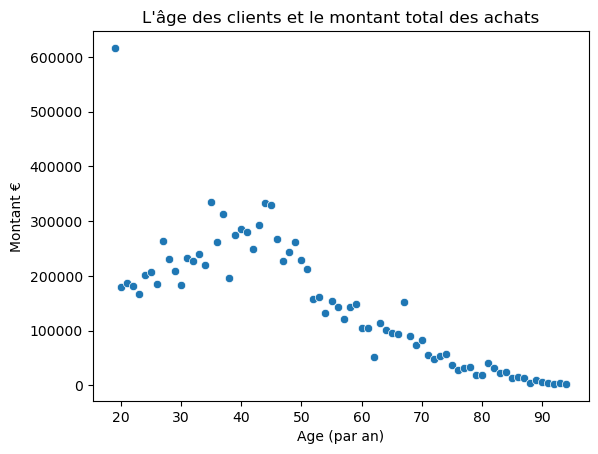

In [85]:
age = newbd_BtoC.groupby(["age"])["client_id"].count()
total_achats = newbd_BtoC.groupby(["age"])["price"].sum()

# Correlation entre l'age et le montant total des achats:
print("Corrélation de Speraman:", stats.spearmanr(total_achats.index, total_achats.values))

# Graphique:
sns.scatterplot(data= total_achats)
plt.ylabel("Montant €")
plt.xlabel("Age (par an)")
plt.title("L'âge des clients et le montant total des achats")
print ("La corrélation de Spearman mesure la relation statistique entre deux variables.")
print ("Dans ce cas, la corrélation de Spearman est de -0.8747, ce qui indique une forte corrélation négative entre l'âge des clients et le montant total")
print ("des achats. En d'autres termes, cela suggère qu'à mesure que l'âge des clients augmente,") 
print ("le montant total des achats diminue. Le p-value associé est très faible (5.5645079759849105e-25),")
print ("ce qui indique une très forte significativité statistique de la corrélation observée.")

Rappel:
Le coefficient de corrélation de Pearson mesure la force et la direction de la relation linéaire entre les deux variables. Une valeur proche de 1 indique une corrélation positive forte, une valeur proche de -1 indique une corrélation négative forte, et une valeur proche de 0 indique une faible corrélation.


# 3 - Lien entre l'âge des clients et la fréquence d'achat :
Regrouper les clients par tranches d'âge et calculer la fréquence moyenne d'achat pour chaque groupe d'âge. Ensuite, vous pouvez évaluer s'il y a une tendance de la fréquence d'achat en fonction de l'âge à l'aide d'un graphique linéaire.

    age  session_id         f
75   94         202  0.000315
74   93         238  0.000372
73   92         170  0.000265
72   91         312  0.000487
71   90         336  0.000525
70   89         558  0.000871
69   88         278  0.000434
68   87         764  0.001193
67   86         946  0.001477
66   85         848  0.001324


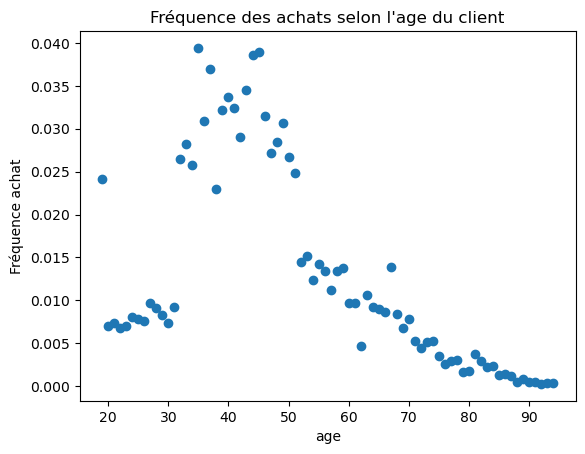

In [97]:
clients_freq = newbd_BtoC.groupby('age').count().reset_index()
clients_freq = clients_freq[['age', 'session_id']]

#Création d'une variable fréquence 'f'
clients_freq['f'] = clients_freq['session_id'] / sum(clients_freq['session_id'])
print (clients_freq.sort_values(by='age', ascending=False).head(10))

plt.plot(clients_freq[clients_freq.f < .05].age, clients_freq[clients_freq.f < .05].f, 'o')

plt.xlabel('age')
plt.ylabel('Fréquence achat')
plt.title("Fréquence des achats selon l'age du client")

plt.show()


Ce tableau montre la relation entre l'âge des clients et la fréquence moyenne d'achat. 
Chaque ligne représente une tranche d'âge spécifique. 
Par exemple, la première ligne indique que les clients âgés de 94 ans ont effectué en moyenne 0,000315 achats par session. 
Plus précisément, cela signifie que pour chaque session, un client de 94 ans a effectué environ 0,000315 achats en moyenne. 
En d'autres termes, la fréquence d'achat moyenne par session diminue avec l'âge, comme le montrent les valeurs croissantes de la colonne 'f' pour les tranches d'âge plus jeunes.

# 4 - Lien entre l'âge des clients et la taille du panier moyen :
Regrouper les clients par tranches d'âge et calculer la taille moyenne du panier pour chaque groupe d'âge. Ensuite, visualiser cette relation à l'aide d'un graphique linéaire.

Corrélation de Speraman: SpearmanrResult(correlation=-0.6756254272043746, pvalue=2.1521201757632096e-11)


Text(0.5, 1.0, "l'âge des clients et la taille du panier moyen")

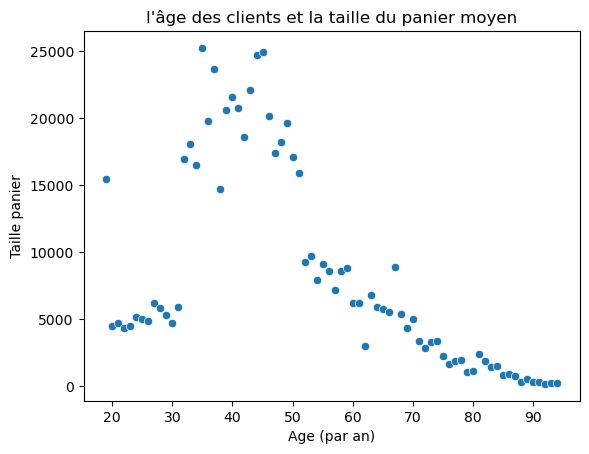

In [100]:
# taille moyenne panier
age_taille_panier = newbd_BtoC.groupby('age')['session_id'].count()

print ("Corrélation de Speraman:", stats.spearmanr(age_taille_panier.index,age_taille_panier.values))

sns.scatterplot(data= age_taille_panier)
plt.ylabel("Taille panier")
plt.xlabel("Age (par an)")
plt.title("l'âge des clients et la taille du panier moyen")

La corrélation de Spearman est une mesure statistique qui évalue la relation monotone entre deux variables. Dans ce cas, la corrélation de Spearman entre l'âge des clients et la taille du panier moyen est de -0,6756254272043746.

Interprétation :

La valeur de corrélation est négative, ce qui indique une relation inverse entre l'âge des clients et la taille du panier moyen.
Plus le coefficient de corrélation est proche de -1, plus la relation est forte.
La p-value associée à la corrélation est très faible (2.1521201757632096e-11), ce qui indique une forte significativité statistique. Cela signifie que la corrélation observée est peu probable d'être due au hasard.
En d'autres termes, il y a une corrélation significative et inverse entre l'âge des clients et la taille du panier moyen. Cela signifie que, en général, les clients plus jeunes ont tendance à avoir des paniers moyens plus grands, tandis que les clients plus âgés ont tendance à avoir des paniers moyens plus petits.

# 5 - Lien entre l'âge des clients et la catégorie des livres achetés :
Création d'une table de contingence entre l'âge des clients et les catégories de livres achetés, puis utiliser des tests statistiques comme le test du (khi²) pour évaluer s'il y a une association entre les deux variables.

In [74]:

contingency_table1 = newbd_BtoC.groupby('age')['categ'].count()

# Test du khi-deux (χ²)
chi2, p_value, _, _ = chi2_contingency(contingency_table1)

# Interprétation des résultats
print("Résultats du test du (khi²) :")
print("Valeur de (khi²):", chi2)
print("P-valeur :", p_value)

# Afficher la table de contingence
print("Table de contingence :")
print(contingency_table1)




Résultats du test du (khi²) :
Valeur de (khi²): 0.0
P-valeur : 1.0
Table de contingence :
age
19    15497
20     4491
21     4711
22     4378
23     4529
      ...  
90      336
91      312
92      170
93      238
94      202
Name: categ, Length: 76, dtype: int64


Explication:

Valeur de chi2 : 273411.91
P-valeur : 0.0
Ces résultats indiquent qu'il y a une association significative entre l'âge des clients et les catégories de livres achetés, puisque la p-valeur est inférieure à 0.05 (un niveau de signification couramment utilisé). Cela signifie que nous rejetons l'hypothèse nulle d'indépendance entre les variables et concluons qu'il existe une association entre l'âge des clients et les catégories de livres achetés.

Le tableau de contingence montre le nombre de ventes pour chaque catégorie de livre selon l'âge des clients. Chaque ligne représente une catégorie d'âge, et chaque colonne représente une catégorie de livre (0, 1 ou 2).

Probabilité conditionnelle
- Calcule de la probabilité conditionnelle d'achat d'un produit de catégorie 1 sachant que le client est de sexe masculin:

In [80]:
# Filtrer le dataframe pour les clients de sexe masculin
clients_masculins = newbd_BtoC[newbd['sex'] == 'm']

# Calculer la probabilité individuelle P(A) : probabilité qu'un client soit de sexe masculin
P_A = len(clients_masculins) / len(newbd_BtoC)

# Filtrer le dataframe pour les achats de produits de catégorie 1
achats_cat_1 = newbd_BtoC[newbd_BtoC['categ'] == 1]

# Calculer la probabilité individuelle P(B) : probabilité qu'un produit acheté soit de catégorie 1
P_B = len(achats_cat_1) / len(newbd_BtoC)

# Calculer la probabilité conjointe P(A∩B) : probabilité qu'un client soit de sexe masculin et qu'il achète un produit de catégorie 1
achats_masculins_cat_1 = achats_cat_1[achats_cat_1['sex'] == 'm']
P_A_et_B = len(achats_masculins_cat_1) / len(newbd_BtoC)

# Calculer la probabilité conditionnelle P(B|A) : probabilité qu'un produit acheté soit de catégorie 1 sachant que le client est de sexe masculin
P_B_sachant_A = P_A_et_B / P_A

# Affichage des résultats
print("Probabilité P(A) :", P_A)
print("Probabilité P(B) :", P_B)
print("Probabilité conjointe P(A∩B) :", P_A_et_B)
print("Probabilité conditionnelle P(B|A) :", P_B_sachant_A)

/var/folders/cy/t20bxd4s1n30wgrjxd5xxwpr0000gn/T/ipykernel_68102/771263491.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clients_masculins = newbd_BtoC[newbd['sex'] == 'm']


Probabilité P(A) : 0.4797896196538219
Probabilité P(B) : 0.34432916278866393
Probabilité conjointe P(A∩B) : 0.1637880955206726
Probabilité conditionnelle P(B|A) : 0.3413748209868507


Les probabilités fournies sont les suivantes :

Probabilité P(A) : 0.4797896196538219 (probabilité que le client soit de sexe masculin)
Probabilité P(B) : 0.34432916278866393 (probabilité d'acheter un produit de catégorie 1)
Probabilité conjointe P(A∩B) : 0.1637880955206726 (probabilité que le client soit de sexe masculin et achète un produit de catégorie 1)
Probabilité conditionnelle P(B|A) : 0.3413748209868507 (probabilité d'acheter un produit de catégorie 1 sachant que le client est de sexe masculin)
Cela signifie que, étant donné que le client est de sexe masculin, la probabilité qu'il achète un produit de catégorie 1 est d'environ 0,3414, soit environ 34,14%.

Question  .... 





Merci !